<a href="https://colab.research.google.com/github/hsym-uec/myWeb_github/blob/main/Simmple_Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
# Nintendo Stock data from Stooq.com 7974.JP
# reference https://seanmemo.com/234/

from PIL import Image
import tkinter as tk
import tkinter.ttk as ttk
import mplfinance as mpf
import datetime
from datetime import timedelta
from pandas_datareader import data
import pandas as pd
global tree
global df
global stdata
stdata = pd.read_csv(filepath_or_buffer="data.csv", encoding="ms932", sep=",")
global DaysList
DaysList = pd.read_csv(filepath_or_buffer="DaysList.csv", encoding="ms932", sep=",")

def btn_click():
    global df
    global stdata
    global DaysList

    #入力を受け取る
    code = stdata[stdata["name"] == variable1.get()]["code"].to_string(index=False)
    #code = txt1.get()   
    days = DaysList[DaysList["disp"] == variable2.get()]["num"].to_string(index=False)
    #days = txt2.get()
    #days = input("範囲指定:")

    #stooqからデータ取得
    today = datetime.date.today()
    start = today - timedelta(float(days))
    end = today
    df = data.DataReader(code, 'stooq', start, end)

    #グラフ表示
    window = tk.Toplevel()
    window.geometry("800x575")
    window.title(variable1.get() + "    範囲：" + variable2.get())

    fig = 'fig/test.png'
    # イメージ作成
    dfs = df.sort_index()
    mpf.plot(dfs,type='candle',mav=(3, 6, 9),volume=True,savefig=fig)
    img = Image.open(fig)
    h = img.height
    w = img.width
        
    # キャンバス作成
    canvas = tk.Canvas(window, bg="white", height=h, width=w)
    # キャンバス表示
    canvas.place(x=0, y=0)
    # キャンバスにイメージを表示
    img = tk.PhotoImage(file=fig)
    canvas.create_image(0, 0, image=img, anchor=tk.NW)
    
    window.mainloop()


def selected(event):
    for item in tree.selection():
        print(item, tree.item(item))

def change_table():
    global tree
    # Load .csv
    df = pd.read_csv("data.csv", encoding='shift-jis')
    # create Window and Treeview
    table = tk.Tk()
    tree = ttk.Treeview(table, show='headings')
    # set Treeview columns
    tree['column'] = ("No",) + tuple(df)
    # set header
    tree.heading("No", text="No")
    for c in df:
        tree.heading(c, text=c)
    # set cells on the row
    for i, row in enumerate(df.itertuples()):
        tree.insert("", "end", tags=i, values=row)
    # set layout
    tree.pack()
    # bind action
    tree.bind('<<TreeviewSelect>>', selected)
    # set loop
    root.mainloop()
    

    
#ウィンドウ表示
root = tk.Tk()
root.title("株価表示")
root.geometry("300x200")

#テキスト
#lbl1 = tk.Label(text='銘柄追加')
#lbl1.place(x=30, y=40)
lbl2 = tk.Label(text='銘柄：')
lbl2.place(x=30, y=70)
lbl3 = tk.Label(text='範囲：')
lbl3.place(x=30, y=100)

#テキストボックス
#txt1 = tk.Entry(width=20)
#txt1.place(x=80, y=40)
#txt2 = tk.Entry(width=20)
#txt2.place(x=80, y=100)

#プルダウン
variable1 = tk.StringVar(root)
opt1 = tk.OptionMenu(root, variable1, *stdata["name"])
opt1.config(width=20)
#opt1.pack()
opt1.place(x=80, y=70)

variable2 = tk.StringVar(root)
opt2 = tk.OptionMenu(root, variable2, *DaysList["disp"])
opt2.config(width=20)
#opt2.pack()
opt2.place(x=80, y=100)

#ボタン
btn = tk.Button(text='グラフ表示', command=btn_click)
btn.pack(side=tk.BOTTOM, fill=tk.X)
btn2 = tk.Button(text='銘柄確認', command=change_table)
btn2.place(x=30,y=30)

root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/yanagiyasouryou/.pyenv/versions/3.11.3/lib/python3.11/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/rx/fqxz043n4fl_93p8qnw7c9n40000gn/T/ipykernel_48343/1464388162.py", line 33, in btn_click
    start = today - timedelta(float(days))
                              ^^^^^^^^^^^
ValueError: could not convert string to float: 'Series([], )'
Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/yanagiyasouryou/.pyenv/versions/3.11.3/lib/python3.11/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/rx/fqxz043n4fl_93p8qnw7c9n40000gn/T/ipykernel_48343/1464388162.py", line 33, in btn_click
    start = today - timedelta(float(days))
                              ^^^^^^^^^^^
ValueError: could not convert string to float: 'Series([], )'
Exception in T

In [141]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-05-30,5892,6015,5890,5990,4847400
2023-05-29,5967,5976,5882,5909,5562300
2023-05-26,5920,5977,5910,5943,4494900
2023-05-25,5891,5917,5854,5876,4434600
2023-05-24,5950,5972,5881,5930,4220900
2023-05-23,6060,6107,5934,5988,7209500
2023-05-22,5999,6060,5989,6060,5098500
2023-05-19,6074,6082,5968,5977,6094600
2023-05-18,6048,6063,5998,6043,8556600


<Axes: xlabel='Date'>

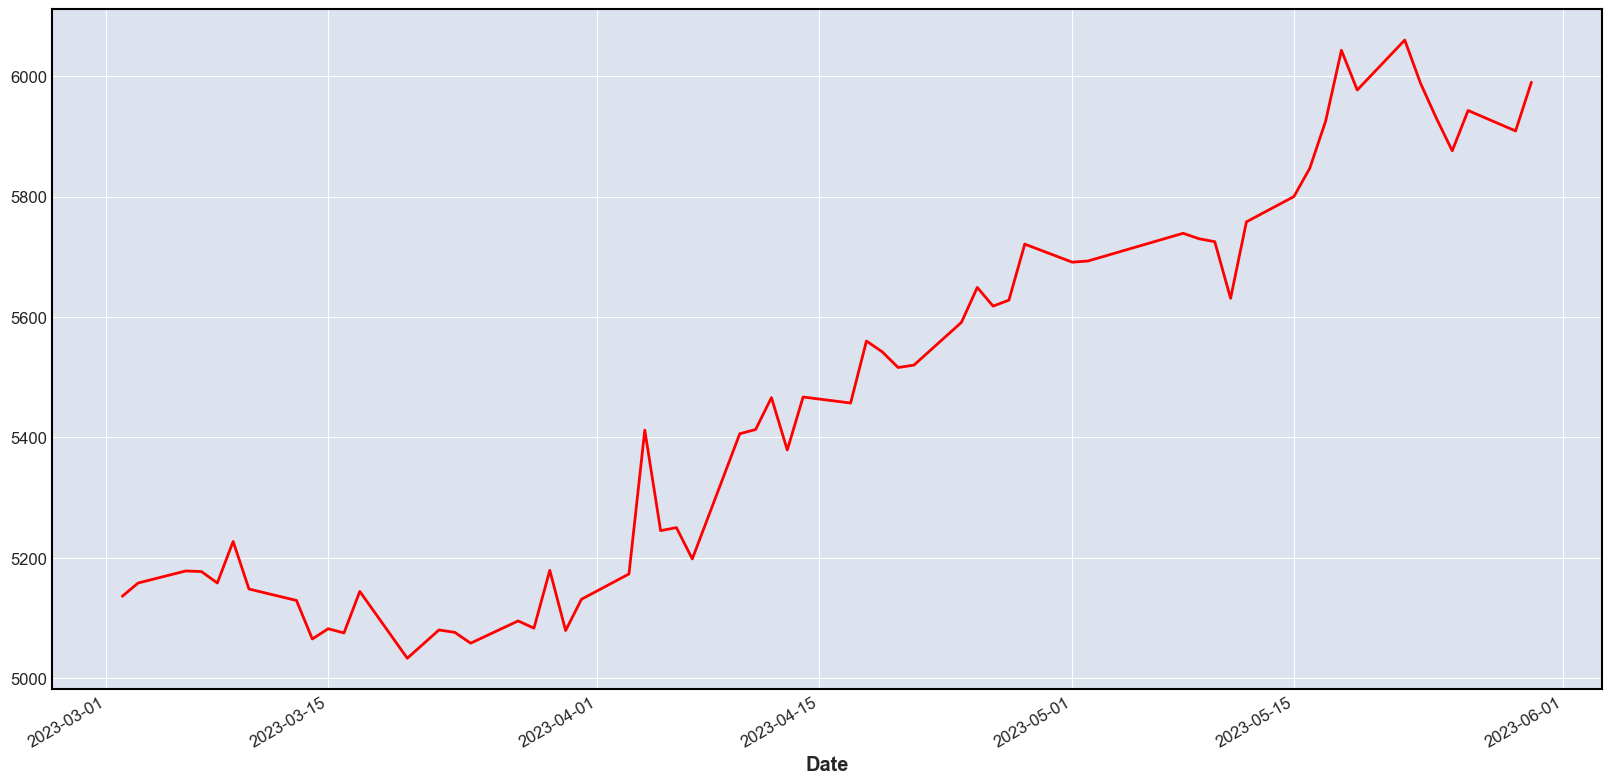

In [142]:
df["Close"].plot(figsize=(20,10), color="red")

In [143]:
# 前日と前々日の差額
df["Close"][0] - df["Close"][1]

81

In [144]:
df["Close"]["2023-05-16"]

5847

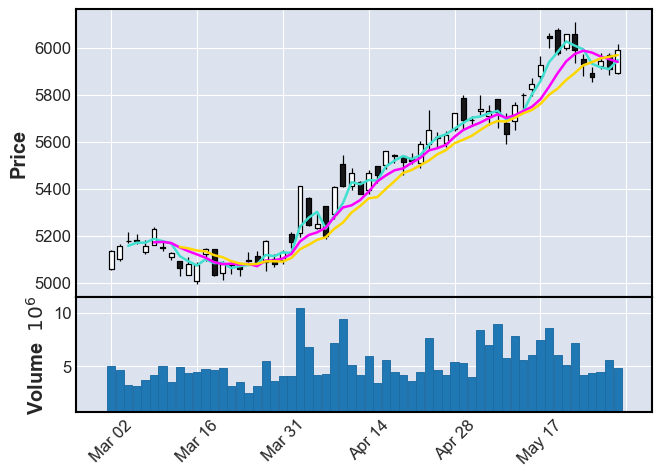

In [145]:
dfc = df.sort_index()
mpf.plot(dfc,type='candle',mav=(3, 6, 9),volume=True)